In [17]:
import sys
import os

# Add the root folder to path (assuming /Notebooks/ is in /DL_Final_Project/)
project_root = os.path.abspath("..")
sys.path.append(project_root)

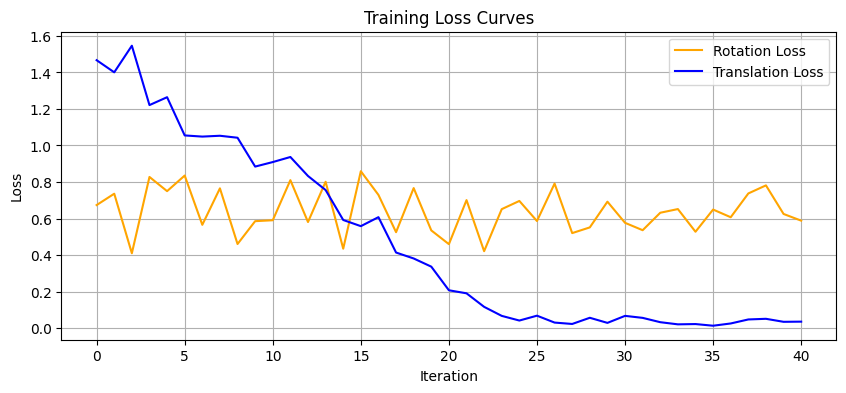

In [18]:
# Cell 1: Visualize training losses
import json
import numpy as np
import matplotlib.pyplot as plt

modalities = '2x'

# Load both JSON files.
with open(f"../trans_loss_{modalities}", "r") as f:
    trans_losses = json.load(f)

with open(f"../rot_loss_{modalities}", "r") as f:
    rot_losses = json.load(f)

episodes = np.arange(1, len(trans_losses) + 1)

plt.figure(figsize=(10, 4))
plt.plot(rot_losses, label="Rotation Loss", color="orange")
plt.plot(trans_losses, label="Translation Loss", color="blue")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss Curves")
plt.legend()
plt.grid(True)
plt.show()


In [19]:
# --- Imports ---

import json
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.autograd import Variable
from tqdm import tqdm
import os
import yaml
import sys

# --- Local Import ---
from Models.model_fusenet_2mod import FuseNetPoseModel
from Scripts.IPDDataset import IPDValidationDataset


In [20]:
 # --- Config ---

config_path = "../Config/config_fusenet_4.yaml"

with open(config_path, "r") as f:
    config = yaml.safe_load(f)

data_root = f"../{config['dataset']['root_dir']}"
cam_ids = config["dataset"]["cam_ids"]
modalities = config["dataset"].get("modality", ["rgb", "depth"])
split = config['dataset'].get('split', 'val')
batch_size = int(config["training"]["batch_size"])
epochs = int(config["training"]["epochs"])
num_workers = int(config["training"]["num_workers"])
device = torch.device(config["training"]["device"] if torch.cuda.is_available() else "cpu")

lr_rot = float(config["optim"]["lr_rot"])
lr_trans = float(config["optim"]["lr_trans"])

print("\n------Configurations------")
print(f"Data Root: {data_root}")
print(f"Cam IDs: {cam_ids}")
print(f"Modalities: {modalities}")
print(f"Split: {split}")
print(f"Batch Size: {batch_size}")
print(f"Epochs: {epochs}")
print(f"Num Workers: {num_workers}")
print(f"Device: {device}")
print(f"Learning Rate (Rotation): {lr_rot}")
print(f"Learning Rate (Translation): {lr_trans}")

# --- Dataset ---
dataset = IPDValidationDataset(root_dir=data_root, cam_ids=cam_ids, modalities=modalities, split=split)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# --- Model ---
in_channels = len(modalities)
# model = nn.DataParallel(FuseNetPoseModel(in_channels=in_channels)).to(device)
model = FuseNetPoseModel(in_channels=in_channels).to(device)


------Configurations------
Data Root: ../ipd_data/ipd
Cam IDs: ['cam2']
Modalities: ['rgb', 'depth', 'aolp', 'dolp']
Split: val
Batch Size: 4
Epochs: 1
Num Workers: 4
Device: cpu
Learning Rate (Rotation): 0.0001
Learning Rate (Translation): 0.001
Loading val data from ../ipd_data/ipd\val

------Initiating FuseNetPoseModel------



In [ ]:
# Cell 2: Visualize prediction vs ground truth
import os
import cv2
import numpy as np
import torch
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt

from Models.helpers import quaternion_to_matrix

# Choose between: "axes" or "bbox"
render_mode = "bbox"

def draw_pose_axes(image, R, t, K, length=0.05, label="", color=(0, 255, 0)):
    """Draws 3D coordinate axes projected into the image."""
    axes = np.float32([[length,0,0], [0,length,0], [0,0,length]]).reshape(-1,3)
    origin = np.zeros((1,3), dtype=np.float32)
    pts_3d = np.vstack((origin, axes))
    pts_2d, _ = cv2.projectPoints(pts_3d, cv2.Rodrigues(R)[0], t, K, None)
    pts_2d = pts_2d.reshape(-1, 2).astype(int)

    img = image.copy()
    cv2.line(img, pts_2d[0], pts_2d[1], color, 2)  # X
    cv2.line(img, pts_2d[0], pts_2d[2], color, 2)  # Y
    cv2.line(img, pts_2d[0], pts_2d[3], color, 2)  # Z
    return img

def draw_bbox_from_pose(image, R, t, K, size=(0.1, 0.1, 0.1), label="", color=(255, 255, 0)):
    """Draws 2D projected bounding box of a 3D cube."""
    w, h, d = size
    # 8 corners of 3D bounding box
    bbox_3d = np.array([
        [0, 0, 0],
        [w, 0, 0],
        [0, h, 0],
        [0, 0, d],
        [w, h, 0],
        [w, 0, d],
        [0, h, d],
        [w, h, d]
    ], dtype=np.float32)

    pts_2d, _ = cv2.projectPoints(bbox_3d, cv2.Rodrigues(R)[0], t, K, None)
    pts_2d = pts_2d.squeeze(1).astype(int)

    x_min, y_min = np.min(pts_2d, axis=0)
    x_max, y_max = np.max(pts_2d, axis=0)

    img = image.copy()
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, 2)
    return img

# Load a sample
x, R_gt, t_gt, K = dataset[1]
x = x.unsqueeze(0).to(device)
R_gt = R_gt.unsqueeze(0).to(device)
t_gt = t_gt.unsqueeze(0).to(device)
print(f"R_gt: {R_gt}")
print(f"t_gt: {t_gt}")


# Load model weights
file_path = f"../weights/fusenet_pose_{len(modalities)}.pkl"
if os.path.exists(file_path):
    print("Loading model weights...")
    model.load_state_dict(torch.load(file_path))

model.eval()

# Predict pose
with torch.no_grad():
    quat, trans, rot_loss, trans_loss  = model(x, R_gt, t_gt)
    print(f"Quat: {quat}")
    print(f"Trans: {trans}")
    print(f"Rot Loss: {rot_loss}")
    print(f"Trans Loss: {trans_loss}")
    R_pred = quaternion_to_matrix(quat).squeeze(0).cpu().numpy()
    t_pred = trans.squeeze(0).cpu().numpy()

R_gt_np = R_gt.squeeze(0).cpu().numpy()
t_gt_np = t_gt.squeeze(0).cpu().numpy()
K = K.numpy()

# Convert image to RGB
img_gray = x.squeeze(0)[0].cpu()
img_pil = ToPILImage()(img_gray)
img_rgb = np.array(img_pil.convert("RGB"))

# Draw based on render mode
vis = img_rgb.copy()

if render_mode == "axes":
    vis = draw_pose_axes(vis, R_gt_np, t_gt_np, K, label="gt", color=(255, 0, 0))
    vis = draw_pose_axes(vis, R_pred, t_pred, K, label="pred", color=(0, 255, 0))
elif render_mode == "bbox":
    vis = draw_bbox_from_pose(vis, R_gt_np, t_gt_np, K, label="gt", color=(255, 0, 0))
    vis = draw_bbox_from_pose(vis, R_pred, t_pred, K, label="pred", color=(0, 255, 0))

plt.figure(figsize=(8, 6))
plt.imshow(vis)
plt.title("GT (red) vs Pred (green) - " + render_mode.upper())
plt.axis("off")
plt.show()


R_gt: tensor([[[ 0.9410, -0.3193,  0.1120],
         [-0.0541,  0.1847,  0.9813],
         [-0.3340, -0.9295,  0.1565]]])
t_gt: tensor([[-0.0894, -0.1270,  2.0002]])
Loading model weights...


C:\Users\RoseP\AppData\Local\Temp\ipykernel_10236\2492555094.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(file_path))
